# Data Science lab - Ex 3

In the previous exercise, I added the ***'number of suspects', 'number of apprehended suspects'***, and ***'Law enforcement effectiveness'*** features to each case, and calculated the mean of the effectiveness (_effectiveness being expressed as how many suspects out of the total of suspects in each crime were apprehended alive--_) over all crimes city-wise and state-wise.



As those features don't really give us an insight on how many people were killed in each case, as they relate to a different kind of information, i deicede to discard them from the training set. _(effectiveness was measured by the number of appreheneded suspects, and this number wont be correlated with how many people died)_

One feature though (that i added in ex2) , that i think might be useful is the modification i did on the **gun_stolen** column to contain **"True"** if a stolen gun was used in the crime, and **"False"** otherwise, so i'll add it up once we load the dataset.

## Question 1

Let's load up the data

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("ex3.csv")

### Organizing The data

Before we try to predict the **n_killed** feature, let's rid of the textual columns and clean the data, and rid of other columns that are not correlated (not the data science correlation) with **n_killed**, as we don't want our model to take them in consideration when predicting.

In [3]:
unwanted_cols = ["Unnamed: 0",
                 #"n_killed",
                 # "n_injured",
                 "participant_type", # can be modified
                 "participant_status",
                 "notes",
                 "incident_id", # leakage
                 # "date", # does killing depend on the date? maybe
                 "address",  # too specific and high cardinality - better to use county/state"
                 "gun_type", # not relevant
                 "incident_characteristics",
             # "latitude", # MIGHT be relevant
             # "longitude", # MIGHT be relevant
                 "location_description",
                 "participant_age",
                 "participant_age_group",
             "participant_gender", # MIGHT be relevant, needs tuning
                 "participant_name",
                 "participant_relationship", 
             "congressional_district",# MIGHT be relevant - categorical data, should be checked
             "state_house_district", # MIGHT be relevant - categotical data, should be checked
             "state_senate_district" # MIGHT be relevant - categotical data, should be checked
                ]
df.drop(columns=unwanted_cols, inplace=True)

And we're left with the following features

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             30000 non-null  object 
 1   state            30000 non-null  object 
 2   city_or_county   30000 non-null  object 
 3   n_killed         30000 non-null  int64  
 4   n_injured        30000 non-null  int64  
 5   gun_stolen       17570 non-null  object 
 6   latitude         28982 non-null  float64
 7   longitude        28982 non-null  float64
 8   n_guns_involved  17577 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 2.1+ MB


Leaving the dependant **n_killed** feature was no mistake, i intend to remove it after the Cleaning portion to the data :)

Our model had many categorical features, and many other that are non relevant, we tried to look for features that can _"hint"_ to us, or seem correlated with the number of people killed in the crime.

But looking at the selection we chose, i can't seem but notice the number of missing values in the features **gun_stolen** and **n_guns_involved**, it pains me to think that imputing those to 0, or training a model to guess the true value will feel a bit superificial to the data, as the number of missing values is almost half the data set.

not to mention that the feature **n_killed**, contains the value 'x::Unknown', which is also a non-NaN value for NaN.

Which leaves me...no other choice...but to massacre my boy.

Nonetheless,i'll be adding new features to replace the categorical data, that mat help in our prediction.

In [5]:
df.drop(columns=['gun_stolen', 'n_guns_involved'], inplace = True)

### Imputation

In the previous section we deleted 2 features because there were alot of missing values in them.

2 features remained with null values - **latitude and longitude**

I'll impute them with the mean of the county itself.

In [6]:
for column in ['longitude', 'latitude']:
    means = df.groupby(['city_or_county'])[column].mean()
    df = df.set_index(['city_or_county'])
    df[column] = df[column].fillna(means)
    df = df.reset_index()

A few NaN values remain - 83, which are probably caused by cities/counties with no logitude/latitude data in the first place, and since they're so few we'll just remove them

In [7]:
df.dropna(inplace=True)

### Categorical Data

Since **state** and **city_or_county** are categorical features, both of which have high cardinality, I decided to encode them using ***frequency encoding***, due to the fact that numerical ordered (such as Hot encoding) methods will give higher value for data more than others, which i think would be problamatic in this case for predicting, and enlarge our dataset intensively.

For each crime, we'll add a statistic that holds the number of crimes made in that month, county-wise and state-wise.

In [8]:
df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d').dt.to_period('M') # convert date to month-year

In [9]:
month_state_stat = df.groupby(['state','date']).size()
month_state_stat = month_state_stat.to_frame().rename(columns={0 : 'state_month_count'})
month_state_stat

state_month_count
state   date                      
Alabama 2014-01                 20
        2014-02                 15
        2014-03                 17
        2014-04                 14
        2014-05                 17
...                            ...
Wyoming 2017-05                  6
        2017-06                  2
        2017-07                  1
        2017-08                  2
        2018-01                  1

[2479 rows x 1 columns]

Crime-count by month, for state

Let's do that for county as well

In [10]:
month_county_stat = df.groupby(['city_or_county','date']).size()
month_county_stat= month_county_stat.to_frame().rename(columns={0 : 'county_month_count'})
month_county_stat

county_month_count
city_or_county date                       
Abbeville      2014-06                   1
               2014-08                   1
               2014-11                   1
               2015-01                   1
               2015-07                   1
...                                    ...
Zion           2016-07                   1
               2017-08                   1
               2018-02                   1
Zionsville     2016-02                   1
Zwolle         2016-04                   1

[17625 rows x 1 columns]

For now, we'll merge the data with the original data frame, and get rid of the 'date' column, since now we hold more relevant information about the crime rate in each month for every crime.

In [11]:
df = df.merge(month_county_stat, on=['city_or_county','date'], how='left')

And add the state crime count by date as well

In [12]:
df = df.merge(month_state_stat, on=['state','date'], how='left')

In [13]:
df

,city_or_county,date,state,n_killed,n_injured,latitude,longitude,county_month_count,state_month_count
0,Humboldt County (county),2017-06,California,0,0,40.7450,-123.8700,1,72
1,Gwinnett (county),2015-12,Georgia,0,0,33.9997,-84.0148,1,35
2,Rocky Mount,2017-11,North Carolina,0,0,35.9934,-77.8066,1,32
3,Odessa,2016-08,Texas,0,0,31.8876,-102.3410,2,50
4,Amityville,2015-05,New York,1,2,40.6923,-73.4185,1,31
...,...,...,...,...,...,...,...,...,...
29912,Grovetown,2015-06,Georgia,0,0,33.4554,-82.2044,1,31
29913,Yonkers,2014-11,New York,0,0,40.9401,-73.8890,1,33
29914,Roy,2014-10,Washington,0,0,47.0030,-122.5430,1,8
29915,Newport News,2018-03,Virginia,0,1,36.9959,-76.4245,1,11


Cool, there's one more thing we need to do before training our model, but first, since we replaced the categorical data, we no longer need them in our dataset.

In [14]:
df.drop(columns=['state','city_or_county','date'], inplace = True)

And of-course, seperate the dependent feature

In [15]:
y_response = df['n_killed']

In [16]:
df.drop(columns = ['n_killed'], inplace = True)

### Scaling

Let's take a look at a boxplot of the feature set

In [17]:
import seaborn as sns

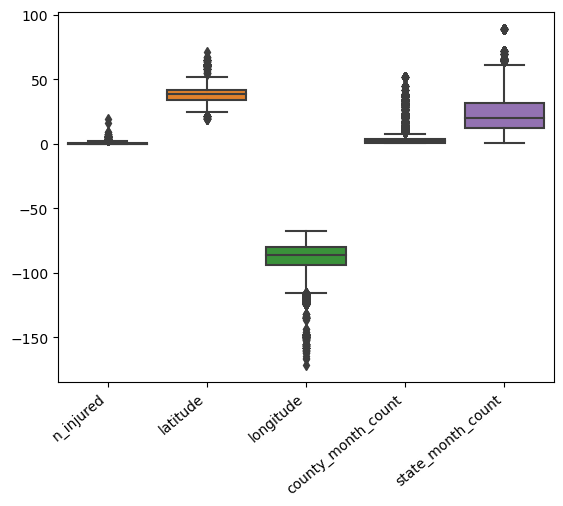

In [18]:
f = sns.boxplot(data=df)
a = f.set_xticklabels(f.get_xticklabels(), rotation=40, ha="right")

We can see the difference in the range of values in each set, it's important to me for the model to not misinterpret features as important or not important, as i'm seeking to learn the true effects of the independent features on the dependent.

thus we'll scale the data and have an another look

In [19]:
from sklearn.preprocessing import StandardScaler

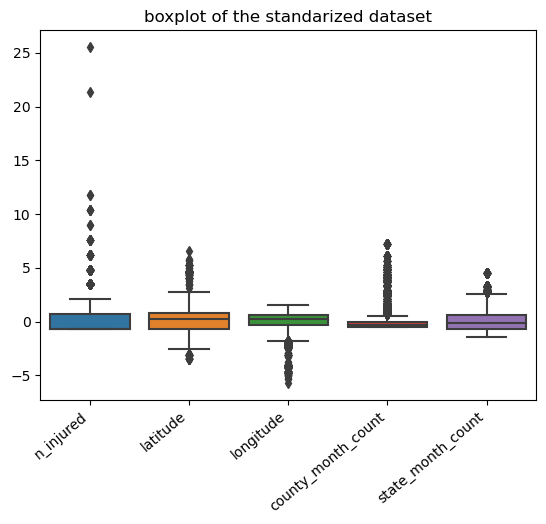

In [20]:
scaler = StandardScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)


f = sns.boxplot(data=df_normalized)
f.set_title("boxplot of the standarized dataset")
a = f.set_xticklabels(f.get_xticklabels(), rotation=40, ha="right")

Much better :), Let's move on to training our models.

### Training the models, and the training metric

After revising the preprocessing previous part around 1000 times, and finally settling down for how to better handle the data, let's move on to choosing and training our models

At first, i wanted to train a linear regression model with MAE for the reason of the response data having very small variance (99% in the range 0-3), i didn't want the model to give that much of a focus on the outliers, which are crimes with high number of victims, as they are only a few.

After looking for a somewhat of alot of time for models which are trained with MAE (mainly linear regression), and can be done so without any additional 'indirect' ways to do so (i know my lack of experience was a factor), i remembered the way we handled outliers in class, and since they're only very few, and in reality almost rare, the solution of removing them from the set both stopped me from worrying about the model being a bit more 'biased' towards outliers, and saved me the hassle of having to train a model with MAE in an undirect way, rather a clean code and understood method.

We'll do that in a bit, for now i chose these 2 models to train on my data

- **Linear Regression model with MSE**, as i want to test the linear relationship between the feature set and the response, it's interesting to see how 'linear' the relationship actually is, and how accurate it might be, this model although might overlook a more complex relationship between the feature set and the response, as it is simply linear.
- **KNN** - i believe if there was a similarity, somehow, between the stats of the crime, and how many people died, KNN will be able to find it, it's interesting to put that to test, the only disadvantage is to remember that even if this model performs well, it's probably a bit more complicated than that, but any way, i think we need more features and info to really get a grip on how the real-situation really behaves.

### Linear Regression model

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import plotly as plt
import numpy as np

In [22]:
x_train, x_test, y_train, y_test = train_test_split(df, y_response, test_size = 0.5)

In [23]:
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)

LinearRegression()

Before checking the performance of the linear mode, let's get a sneak peek on it's coeffs

In [24]:
pd.DataFrame(lin_reg.coef_, df.columns, columns = ['Coeff'])

,Coeff
n_injured,-0.125870
latitude,-0.008788
longitude,-0.002474
county_month_count,0.000607
state_month_count,-0.000627


Even with scaling, the coefficients are pretty minor, which probably indicates on a weak connection between the feature set and the dependant variable.

In order to be able to better predict the data, we'll do 2 transformations on the predicted values of the model
- **floor** the values - there can't be a 1.5 or 1.3 people killed, so we'll round it down to the lower integer.
- **abs** the values - a negative value is invalid for our prediction, so we'll try the absolute of the data and check our error to see if it was a good idea or not.

In [25]:
y_predicted = lin_reg.predict(x_test)
y_predicted = np.floor(np.abs(y_predicted))
def mae(y_true, predictions):
    y_true, predictions = np.array(y_true), np.array(predictions)
    return np.mean(np.abs(y_true - predictions))
mae(y_predicted, y_test)

0.24901397152216057

in realtion to the response variance

In [26]:
y_test.var()

0.24865777216733045

I believe the linear model sucks at predicting dead people.

let's plot the distrubtion of the values

Text(0.5, 1.0, 'predicted n_killed value distribution with true distribution')

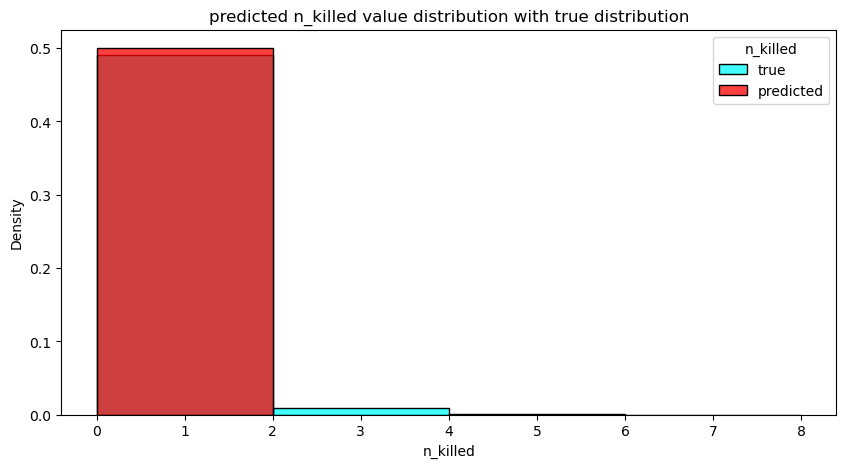

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

f,ax=plt.subplots(1,1,figsize=(10,5))
sns.histplot(data=y_test, color="cyan", label="true", stat="density", binwidth=2)
sns.histplot(data=y_predicted, color="red", label="predicted", stat="density", binwidth=2)
plt.legend(title="n_killed")
ax.set_title("predicted n_killed value distribution with true distribution")

We can see that the model predicted many more 0's than 1's, this can mostly rise from the fact the we 'floored' our data as to not allow for fractions, which means that our predictions were very much dependant on the way we decided to classify and handle our data, for this particular dataset flooring the values helped reduce the MAE error and better classification, since our dataset had more cases that had 0 people killed than any other value in the data set.

I believe a better handling of the data can be applied, and a better 'cutoff' can be found, maybe using the hyperparameter functions we learned in class.

moving on

### KNN

In [28]:
from sklearn.neighbors import KNeighborsClassifier

In [29]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=7)

In [30]:
y_pred = knn.predict(x_test)

/Users/lucas/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


let's check the MAE error of the classifier, and compare with the linear model

In [31]:
mae(y_pred, y_test)

0.2615148071395147

In a way i kinda expected it to perform better than the linear regression model, as it focuses more on the similarities in the data among other samples, i had a small hunch and a bit of worry about how it would perform, but  i'm not too surprised

Let's also plot the predicted values and the true ones by their distributions

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 1.0, 'predicted n_killed value distribution with true distribution')

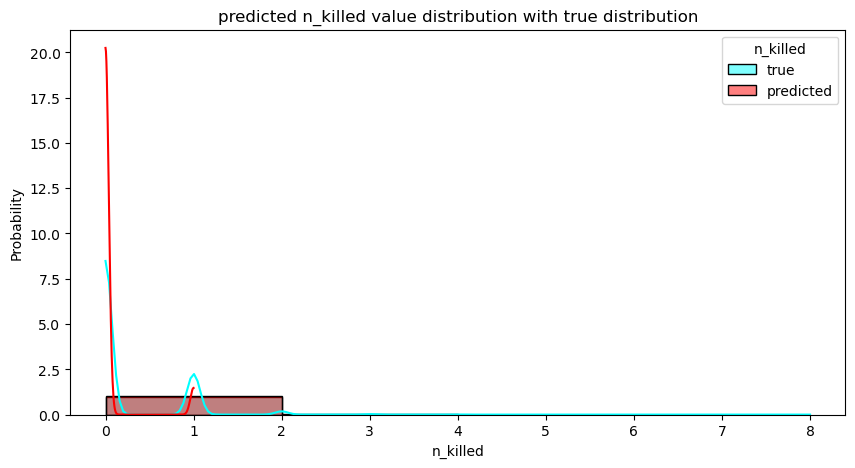

In [33]:
f,ax=plt.subplots(1,1,figsize=(10,5))
sns.histplot(data=y_test, color="cyan", label="true", stat="probability", binwidth=2, kde=True)
sns.histplot(data=y_pred, color="red", label="predicted", stat="probability", binwidth=2, kde=True)
plt.legend(title="n_killed")
ax.set_title("predicted n_killed value distribution with true distribution")

We can see it a tiny bit clearly throught the lines, as the boxes are close to eachother, the difference between the true and the predicted aren't huge, and it seems the KNN model classified alot more cases as having 0 people killed, while it seems it should've classified it as 1, hence the lower line around the value

## Question 2

In this section, let's use the model version of a Linear Regression model on steroids, SVM (i feel sorry for my computer for the upcoming part).

In [34]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestClassifier

We'll control the C along with the degree, and plot the accuracy on the way

Let's define the boundaries first

In [35]:
params_grid = { 
    'degree': [1,2,3,4,5],
    'C': [1,5,10,20,30],
}

In [36]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(df, y_response, test_size = 0.5)

### Grid Search

In [37]:
model = SVC(kernel='linear')

n_configs = np.array([len(l) for key, l in params_grid.items()]).prod()
print('n_configs', n_configs)

grid = GridSearchCV(estimator=model, param_grid=params_grid, cv=3,verbose=1 ,scoring=make_scorer(accuracy_score))

grid.fit(x_train1, y_train1)

print("Done grid search")

n_configs 25
Done grid search


In [38]:
print('Best parameters found in Grid Search', grid.best_params_)
print('Best score in Grid Search', grid.best_score_)
model_gs = grid.best_estimator_

Viola! took only 40 mins

### Random Search

As to condole my laptop with the previous part, i want to check how Random Search will do, how efficient and accurate it is than the Grid Search.

Similar to class

In [39]:
from scipy.stats import randint

rs = RandomizedSearchCV(estimator=model, param_distributions=params_grid, cv=3, verbose=1, scoring=make_scorer(accuracy_score), n_iter=n_configs)

rs.fit(x_train1, y_train1)

print("Done random search")

Done random search


## Question 3

### (a) Reusing the model

In this section, for simplicity, we'll reuse the linear model we trained in Question 1.

We saw it's MAE on the test data, but we didnt get a better look on it's coefficients, let's use the Permutation feature importance we saw in class, and see the results.

In [40]:
from sklearn.inspection import permutation_importance

<AxesSubplot:>

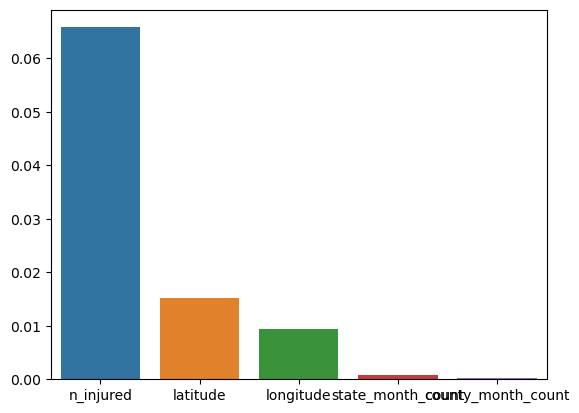

In [41]:
result = permutation_importance(lin_reg, x_train, y_train, n_repeats=10, random_state=1)
feature_importances = sorted(list(zip(x_train.columns, result['importances_mean'])), key=lambda x: -x[1])
columns = list(list(zip(*feature_importances))[0])
importances = list(list(zip(*feature_importances))[1])
sns.barplot(x=columns, y=importances)

Again, the value distribution of the features were scaled, so we see here an accurate representation of the effect of each feature on the response, **n_injured** is the feature that contributed the most, and we can see that much more than any other feature we added.

### (b) Separating the features

Let's train yet another 2 regression models, one only on the **n_injured** feature, and the other with the rest, and check out their 

In [42]:
x_train, x_test, y_train, y_test = train_test_split(df, y_response, test_size = 0.5)

In [43]:
model1 = LinearRegression()
model2 = LinearRegression()

x_train_data_1 = x_train['n_injured']
x_train_data_2 = x_train.drop(columns=['n_injured'])
x_test_data_1 = x_test['n_injured'].values.reshape(-1,1)
x_test_data_2 = x_test.drop(columns=['n_injured'])

In [44]:
model1.fit(x_train_data_1.values.reshape(-1,1), y_train)
model2.fit(x_train_data_2, y_train)

LinearRegression()

In [46]:
model1_mae = mae(model1.predict(x_test_data_1), y_test)
model2_mae = mae(model2.predict(x_test_data_2), y_test)

<AxesSubplot:>

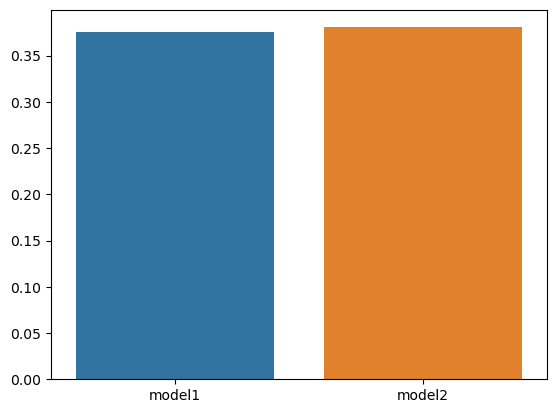

In [47]:
sns.barplot(x=['model1','model2'], y=[model1_mae, model2_mae])

Woah, surprisingly, we can see that model2 actually performed better than the most important feature!, pretty cool.

The real question is, why, maybe the n_injured feature, although important but a tiny bit problamatic, and it 'shadowed' the other features somehow in the previous model.

But as a model that wasn't trained with the mean feature, it did quite amazingly.

Let's look at the featues of the 2

<AxesSubplot:>

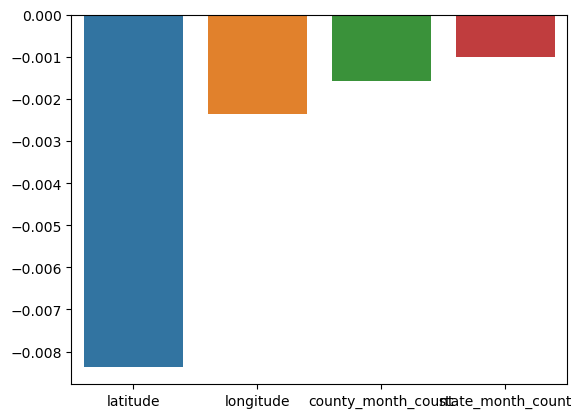

In [48]:
sns.barplot(x=list(x_train_data_2.columns),y=model2.coef_.flatten())

I have to say i'm quite confused at this point, i'm really surprised, but if what i see is true, doesn't it mean that people who live higher are less likely to killeachother? does less oxygen=less killy killy? 

Nah come on, let's think about this logically, usually larger cities are located on a lower latitude, and cities on a high altitude, since they have the issue of being on moutains or between them, seem to be more...scattereed, meaning they're much smaller, as the density of people living there can't be high due to that fact, which means that in larger cities on a lower latitude more crimes are reported, --**maybe** that's one factor that might contribute to the explination we see here.